In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score,roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.5)

In [2]:
data = pd.read_json('ultimate_data_challenge.json')

In [3]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
#Filling in empty values with mean
data.avg_rating_of_driver = data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean()).round(2)
data.avg_rating_by_driver = data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean().round(2))
data.phone = data.phone.fillna(data.phone.mode()[0])

In [6]:
data.signup_date = data.signup_date.astype('datetime64')
data.last_trip_date = data.last_trip_date.astype('datetime64')

In [7]:
#Creating a new column that states whether or not the user was active in the 6th month
data['active_6_mo'] = int()

active_rows = data.last_trip_date.dt.month == 6

data.loc[active_rows,'active_6_mo'] = int(1)
data.loc[~active_rows, 'active_6_mo'] = int(0)

In [8]:
data

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6_mo
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,4.6,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


In [9]:
len(data[data.active_6_mo == 1]) / len(data)

0.36512

# Retention

36.5% of users were still active in the 6th month

In [10]:
# These rows are no longer needed
data.drop(columns=['signup_date', 'last_trip_date'], inplace = True)

In [11]:
#One hot encoding city
one_hot_city = pd.get_dummies(data.city,drop_first=True, prefix='city',dtype=int)
data = pd.concat([one_hot_city, data], axis=1)
data.drop(columns=['city'], inplace=True)

In [12]:
#One hot encoding phone type
one_hot_phone = pd.get_dummies(data.phone, drop_first=True, prefix='phone',dtype=int)
data = pd.concat([one_hot_phone, data], axis=1)
data.drop(columns=['phone'], inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   phone_iPhone            50000 non-null  int32  
 1   city_King's Landing     50000 non-null  int32  
 2   city_Winterfell         50000 non-null  int32  
 3   trips_in_first_30_days  50000 non-null  int64  
 4   avg_rating_of_driver    50000 non-null  float64
 5   avg_surge               50000 non-null  float64
 6   surge_pct               50000 non-null  float64
 7   ultimate_black_user     50000 non-null  bool   
 8   weekday_pct             50000 non-null  float64
 9   avg_dist                50000 non-null  float64
 10  avg_rating_by_driver    50000 non-null  float64
 11  active_6_mo             50000 non-null  int64  
dtypes: bool(1), float64(6), int32(3), int64(2)
memory usage: 3.7 MB


In [14]:
data

,phone_iPhone,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_6_mo
0,1,1,0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,1
1,0,0,0,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0
2,1,0,0,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0
3,1,1,0,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1
4,0,0,1,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,1,0,0,5.0,1.00,0.0,False,100.0,5.63,4.2,1
49996,1,0,0,1,4.6,1.00,0.0,False,0.0,0.00,4.0,0
49997,0,0,1,0,5.0,1.00,0.0,True,100.0,3.86,5.0,0
49998,1,0,0,2,3.0,1.00,0.0,False,100.0,4.58,3.5,0


In [15]:
X = data.drop(columns='active_6_mo')
y = data.active_6_mo

X_train, X_test, y_train, y_test = train_test_split(X.copy(), y, train_size = .75, random_state=30)

In [16]:
non_binary_cols = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge','surge_pct','weekday_pct', 'avg_dist','avg_rating_by_driver']
scaler = StandardScaler()

X_train[non_binary_cols] = scaler.fit_transform(X_train[non_binary_cols])
X_test[non_binary_cols] = scaler.transform(X_test[non_binary_cols])

In [17]:
X_test

,phone_iPhone,city_King's Landing,city_Winterfell,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
34627,1,1,0,5.482525,0.528354,-0.154510,-0.069277,False,0.144765,-0.694138,0.049958
31443,0,0,1,-0.602451,0.706524,-0.334313,-0.441317,False,1.053773,0.221630,0.498013
41987,1,1,0,-0.073323,0.350183,0.025292,-0.054194,True,-1.435884,-0.394206,0.049958
34402,1,0,0,1.514062,0.172013,-0.334313,-0.441317,True,0.638381,-0.523762,0.273985
39027,0,0,0,-0.602451,-0.006158,-0.334313,-0.441317,False,-0.294903,-0.161714,0.498013
...,...,...,...,...,...,...,...,...,...,...,...
5294,1,0,1,1.778626,0.706524,1.149059,1.232865,False,1.053773,0.072552,0.498013
38876,1,0,1,-0.073323,-0.184328,-0.334313,-0.441317,True,1.053773,0.452347,-1.742264
31460,1,0,1,-0.602451,0.706524,-0.334313,-0.441317,True,-0.834374,-0.458097,0.273985
296,1,0,1,-0.073323,0.706524,-0.334313,-0.441317,False,-0.745361,-0.497141,0.498013


# Linear Support Vector Classifier

In [18]:
losses = ['hinge', 'squared_hinge']
duals = [True,False]
learning_rates = list(np.logspace(-3,2,6))
penalties = ['l1','l2']
max_iters = [1000, 5000, 10000, 20000, 50000, 150000]

random_grid = {
    'C': learning_rates,
    'penalty': penalties,
    'max_iter': max_iters,
    'loss': losses,
    'dual': duals
}

SVC = LinearSVC()

SVC_search = RandomizedSearchCV(estimator=SVC, param_distributions=random_grid, n_iter=5, cv=10, scoring = 'roc_auc', n_jobs=-1,random_state=47)

results = SVC_search.fit(X_train, y_train)

In [19]:
results.best_params_

{'penalty': 'l1',
 'max_iter': 5000,
 'loss': 'squared_hinge',
 'dual': False,
 'C': 10.0}

In [20]:
# In order to compute a ROC score easier, the SVC needs to be wrapped around a CalibratedClassifierCV for probabilities of targets
svc = LinearSVC(penalty = results.best_params_['penalty'], 
                max_iter = results.best_params_['max_iter'], 
                loss = results.best_params_['loss'], 
                dual = results.best_params_['dual'], 
                C = results.best_params_['C'])
clf = CalibratedClassifierCV(svc,cv=5)
clf.fit(X_train, y_train)
svc.fit(X_train,y_train)

LinearSVC(C=10.0, dual=False, max_iter=5000, penalty='l1')

In [21]:
# Metrics for test data
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80      8010
           1       0.66      0.45      0.54      4490

    accuracy                           0.72     12500
   macro avg       0.70      0.66      0.67     12500
weighted avg       0.71      0.72      0.70     12500

Accuracy: 0.71888


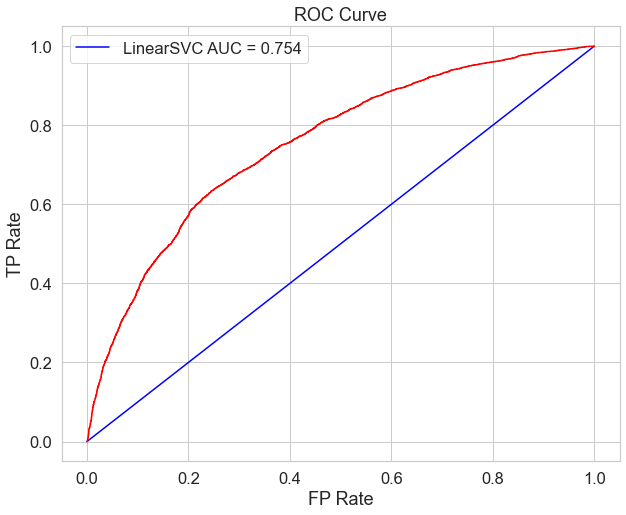

In [22]:
SVC_y_pred_prob = clf.predict_proba(X_test)[:,1]
SVC_score = round(roc_auc_score(y_test,SVC_y_pred_prob),3)

SVC_fpr, SVC_tpr, SVC_thresholds = roc_curve(y_test, SVC_y_pred_prob)

plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(SVC_fpr, SVC_tpr, color='red')

plt.legend(['LinearSVC AUC = ' + str(SVC_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve");

In [23]:
print('Accuracy:',accuracy_score(y_test, y_pred),'\n ROC Score:',SVC_score)

Accuracy: 0.71888 
 ROC Score: 0.754


# Random Forest Classifier

In [24]:
RF_model = RandomForestClassifier()
grid = {
    'bootstrap': [True,False],
    'max_depth': [int(x) for x in np.linspace(50, 110,11)] + [None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [int(x) for x in np.linspace(200, 2000,10)]
}
search = RandomizedSearchCV(RF_model, grid, n_iter=5,scoring='roc_auc', cv=5, n_jobs=-1,random_state=47)
results = search.fit(X_train, y_train)

In [25]:
results.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 68,
 'bootstrap': True}

In [26]:
RF_model = RandomForestClassifier(n_estimators = results.best_params_['n_estimators'], 
                                  min_samples_split = results.best_params_['min_samples_split'], 
                                  min_samples_leaf = results.best_params_['min_samples_leaf'], 
                                  max_features = results.best_params_['max_features'], 
                                  max_depth = results.best_params_['max_depth'], 
                                  bootstrap = results.best_params_['bootstrap'])
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=68, max_features='sqrt', min_samples_leaf=4,
                       n_estimators=400)

In [27]:
y_pred = RF_model.predict(X_test)
print(classification_report(y_test,y_pred))
print('Accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      8010
           1       0.72      0.64      0.67      4490

    accuracy                           0.78     12500
   macro avg       0.76      0.75      0.75     12500
weighted avg       0.77      0.78      0.78     12500

Accuracy: 0.7784


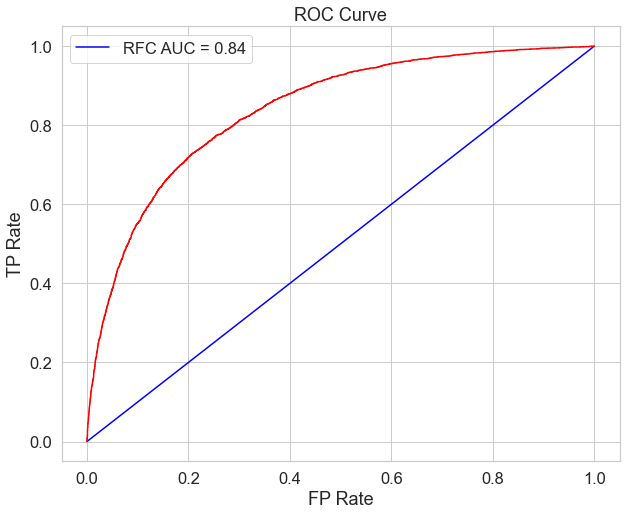

In [28]:
RF_y_pred_prob = results.predict_proba(X_test)[:,1]
RF_score = round(roc_auc_score(y_test,RF_y_pred_prob),3)

RF_fpr, RF_tpr, RF_thresholds = roc_curve(y_test, RF_y_pred_prob)

plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(RF_fpr, RF_tpr, color='red')

plt.legend(['RFC AUC = ' + str(RF_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve");

In [29]:
print('Accuracy:',accuracy_score(y_test, y_pred),'\n ROC Score:',RF_score)

Accuracy: 0.7784 
 ROC Score: 0.84


## Comparison

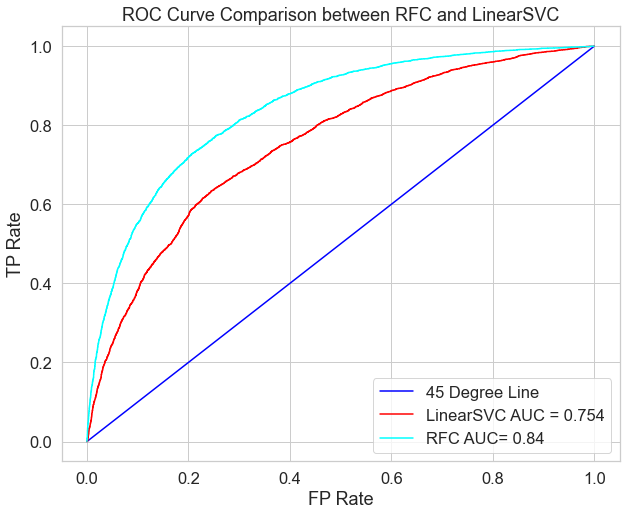

In [30]:
plt.figure(figsize=(10,8))

line_45 = np.linspace(0, 1.0, 20)
plt.plot(line_45, line_45, color='blue')

plt.plot(SVC_fpr, SVC_tpr, color='red')
plt.plot(RF_fpr, RF_tpr, color='cyan')

plt.legend(['45 Degree Line','LinearSVC AUC = ' + str(SVC_score), 'RFC AUC= ' + str(RF_score)],loc='best')
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC Curve Comparison between RFC and LinearSVC");

Random Forest Classifier seems to predict markedly better than LinearSVC.

# Feature Importances

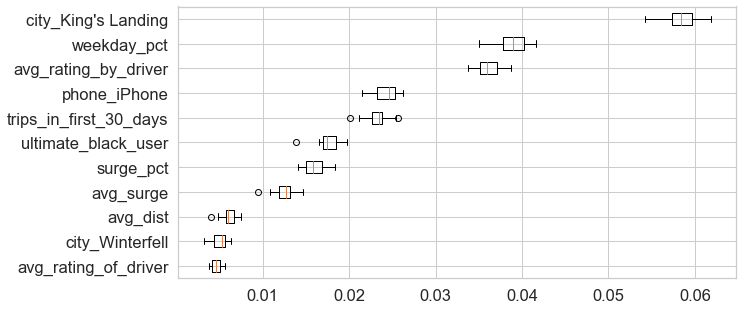

In [31]:
plt.figure(figsize=(10,5))

perm_importance = permutation_importance(RF_model, X_test, y_test,n_jobs=-1,scoring = 'roc_auc',n_repeats=20)

sorted_idx = perm_importance.importances_mean.argsort()

plt.boxplot(perm_importance.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx]);

#### Percentage of Users retained in/outside of King's Landing

In [32]:
in_kings = data.loc[data["city_King's Landing"] == 1]

In [33]:
out_kings = data.loc[data["city_King's Landing"] == 0]

In [34]:
in_kings.active_6_mo.value_counts(normalize=True) * 100

1    60.809477
0    39.190523
Name: active_6_mo, dtype: float64

In [35]:
out_kings.active_6_mo.value_counts(normalize=True) * 100

0    69.6614
1    30.3386
Name: active_6_mo, dtype: float64

King's Landing has a significantly higher percentage of users that choose to stay

#### Wealth Indicators

In [36]:
in_kings.phone_iPhone.value_counts(normalize=True) * 100

1    75.340573
0    24.659427
Name: phone_iPhone, dtype: float64

In [37]:
out_kings.phone_iPhone.value_counts(normalize=True) * 100

1    68.587911
0    31.412089
Name: phone_iPhone, dtype: float64

In [38]:
in_kings.ultimate_black_user.value_counts(normalize=True) * 100

False    58.479763
True     41.520237
Name: ultimate_black_user, dtype: float64

In [39]:
out_kings.ultimate_black_user.value_counts(normalize=True) * 100

False    63.260597
True     36.739403
Name: ultimate_black_user, dtype: float64

#### Surge info

In [40]:
in_kings.surge_pct.mean()

9.966979269496544

In [41]:
out_kings.surge_pct.mean()

8.565620767494357

In [42]:
in_kings.avg_surge.mean()

1.070706811451135

In [43]:
out_kings.avg_surge.mean()

1.0757945823927764

In [44]:
data.corr()['active_6_mo'].sort_values(ascending=False)[1:]

city_King's Landing       0.254378
phone_iPhone              0.219895
ultimate_black_user       0.200222
trips_in_first_30_days    0.193932
surge_pct                 0.010323
weekday_pct               0.003674
avg_surge                -0.003630
avg_rating_of_driver     -0.011980
avg_rating_by_driver     -0.025992
city_Winterfell          -0.046082
avg_dist                 -0.086937
Name: active_6_mo, dtype: float64

After performing permutation importance, the feature that causes the biggest decrease in the ROC score is if if they live in King's landing. After comparing some features that indicate wealth (if user has an iphone, if user uses ultimate_black, surge_pct) I believe that King's landing, on average, has wealthier users. Wealthier users may be willing to continuously use ride-sharing services simply because they can afford to.

Something Ultimate can do is lower surge pricing for those in King's Landing. When looking at the average surge multiplier from both groups, it is the same. Yet, when looking at the customers willing to book a ride with an increased surge, those outside of kings landing choose not to a little less. This could be due to affordability.